## Importing Needed Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler

## Reading The Data

In [4]:
data_dir = '../input/learn-time-series-forecasting-from-gold-price/gold_price_data.csv'
df = pd.read_csv(data_dir)

## Data Exploration

In [5]:
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


In [7]:
df.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


### Set Date column as an index

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace= True)

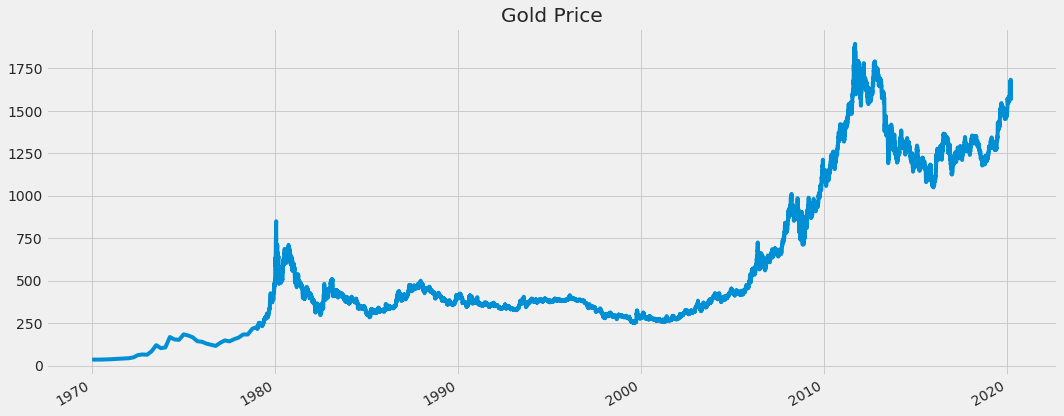

In [9]:
plt.figure(figsize=(15, 6))
df['Value'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Gold Price")
plt.tight_layout()
plt.show()

## Data Preprocessing

### Choosing Prediction Column

In [12]:
n_cols = 1
dataset = df["Value"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape


(10787, 1)

### Normalizing Data

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

### Splitting the Data

In [14]:
# 75% to Train , 25% to Test
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 8090 Test Size : 2697


In [15]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(8090, 1)

### Creating training set

In [20]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 100
n_cols = 1

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[5.37663315e-05],
       [0.00000000e+00],
       [1.61298995e-04],
       [5.91429647e-04],
       [1.23662563e-03],
       [2.04312060e-03],
       [2.68831658e-03],
       [3.70987688e-03],
       [4.51637185e-03],
       [7.09715576e-03],
       [1.45169095e-02],
       [1.63449648e-02],
       [1.54847035e-02],
       [2.65068014e-02],
       [4.57013818e-02],
       [3.65073391e-02],
       [3.84966934e-02],
       [7.16705199e-02],
       [6.39819345e-02],
       [6.27453089e-02],
       [8.00043013e-02],
       [7.64557234e-02],
       [7.06489596e-02],
       [5.82827034e-02],
       [5.65621808e-02],
       [5.05941180e-02],
       [4.72068391e-02],
       [4.34969622e-02],
       [5.34437335e-02],
       [6.08634873e-02],
       [5.77988064e-02],
       [6.47346632e-02],
       [6.98424646e-02],
       [7.97354696e-02],
       [7.96817033e-02],
       [9.78547234e-02],
       [1.02639927e-01],
       [1.02639927e-01],
       [1.03070058e-01],
       [9.8661

In [21]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [22]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [23]:
x_train.shape , y_train.shape

((7990, 100, 1), (7990, 1))

## LSTM Model

### Model Dtructure

In [24]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

2022-11-13 14:33:57.854650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 14:33:57.949107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 14:33:57.949886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 14:33:57.951222: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [26]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32)

2022-11-13 14:34:08.126790: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-13 14:34:11.242978: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 7s 10ms/step - loss: 8.6191e-04 - mean_absolute_error: 0.0118
Epoch 2/100
250/250 [==============================] - 3s 10ms/step - loss: 6.6598e-05 - mean_absolute_error: 0.0050
Epoch 3/100
250/250 [==============================] - 2s 9ms/step - loss: 6.3435e-05 - mean_absolute_error: 0.0050
Epoch 4/100
250/250 [==============================] - 2s 9ms/step - loss: 6.0847e-05 - mean_absolute_error: 0.0050
Epoch 5/100
250/250 [==============================] - 2s 9ms/step - loss: 5.2011e-05 - mean_absolute_error: 0.0046
Epoch 6/100
250/250 [==============================] - 2s 10ms/step - loss: 5.0546e-05 - mean_absolute_error: 0.0046
Epoch 7/100
250/250 [==============================] - 2s 9ms/step - loss: 4.5171e-05 - mean_absolute_error: 0.0044
Epoch 8/100
250/250 [==============================] - 2s 9ms/step - loss: 4.1979e-05 - mean_absolute_error: 0.0042
Epoch 9/100
250/250 [==============================] - 2s 9ms/step - loss: 3.8531

### Model Evaluation

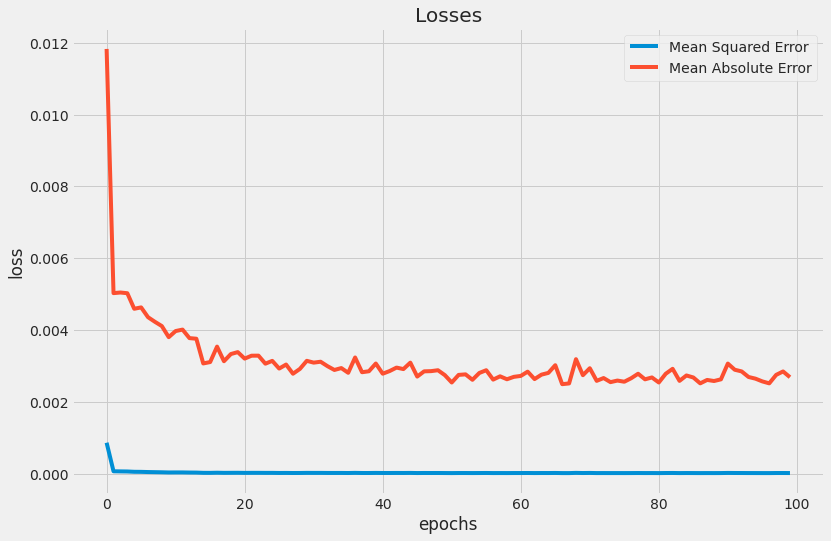

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predection

### Creating testing set

In [28]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [29]:
x_test.shape , y_test.shape

((2697, 60, 1), (2697, 1))

In [30]:
# Get Prediction
predictions = model.predict(x_test)

In [31]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(2697, 1)

### Root mean square error

In [32]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

24.29

In [33]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,1112.566895,1114.75
1,1110.668945,1104.00
2,1101.577759,1130.00
3,1127.871216,1134.75
4,1130.406494,1149.00
...,...,...
2692,1620.485107,1672.50
2693,1604.819092,1655.70
2694,1589.775635,1653.75
2695,1586.996582,1570.70


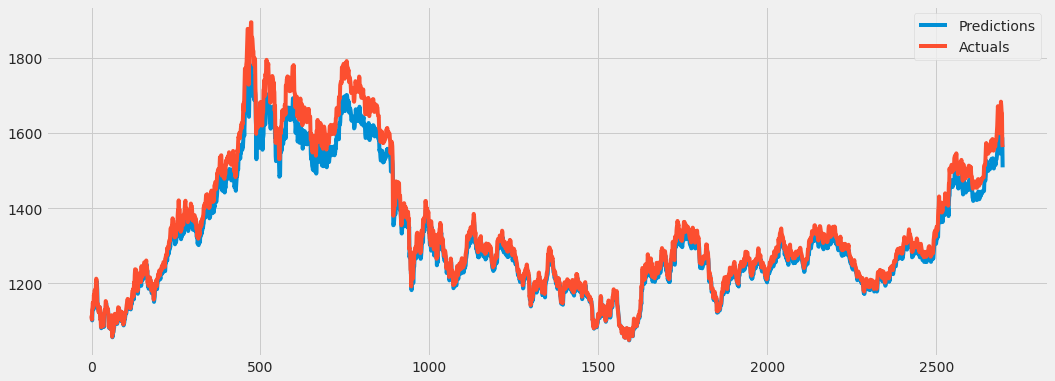

In [34]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

### Visualize Predictions with The Data
for one feature

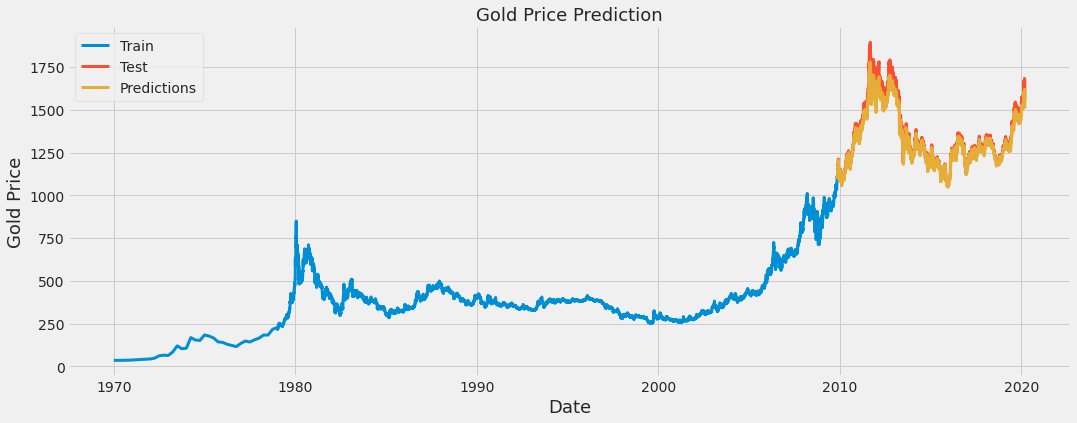

In [35]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Gold Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Gold Price', fontsize= 18)
plt.plot(train['Value'], linewidth= 3)
plt.plot(test['Value'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])